# Solving modifed Helmholtz problems with CG on the GPU.

In [ ]:
import numpy as np
import numba
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numba
from numba import cuda
import math
from scipy.sparse.linalg import LinearOperator, cg
np.set_printoptions(threshold=np.inf)
%matplotlib inline

We allow a larger class of possible PDE problems, namely so called modified Helmholtz problems of the form

$$
-\Delta u + \omega^2 u = f
$$

by introducing an aditional input parameter $\omega$ to the CUDA 5-point stencil (see Poisson-PDE notebook).

We now wrap the solution into a LinearOperator so that we can interface it with the built-in Scipy iterative solvers.

In [ ]:
# CUDA implementation of discrete laplacian operator with shared memory

# Thread block size of interior points
SX = 32 
SY = 32

# Total thread block size including 'halo' boundries
haloSX = SX + 2
haloSY = SY + 2

@cuda.jit
def discretise_poisson_gpu(u_tilda, f, omega, N):
    '''
    Evaluate the linear matrix problem: A_tilda @ u_tilda = f, 
    without the need to define the matrix A_tilda. Boundary values
    are set to zero.
    
    Keyword arguments:
    u_tilda  -- ndarray of shape [(N-2)^2,], corresponding to
                the solution at each interior point
    f        -- ndarray of shape [(N-2)^2,], corresponding to
                the interior nodes
    
    '''
    # Define shared memory
    local_u = cuda.shared.array((haloSX, haloSY), numba.float32)
    
    # Local thread position
    i = cuda.threadIdx.x
    j = cuda.threadIdx.y
    
    # Global thread position
    pi, pj = cuda.grid(2)
    
    if pi >= N-2:
        return
    if pj >= N-2:
        return
    
    # Compute the vector index
    pk = pj * (N - 2) + pi
    
    # Load interior points of each block
    local_u[i + 1, j + 1] = u_tilda[pk]
    
    # Load halo boundries of each block
    if i == 0 and pi != 0:                          # Left edges
        local_u[i, j + 1] = u_tilda[pk - 1]
    if j == 0 and pj != 0:                          # Top edges             
        local_u[i + 1, j] = u_tilda[pk - (N - 2)]
    if i == SX - 1 and pi != (N - 2) - 1:           # Right edges
        local_u[-1, j + 1] = u_tilda[pk + 1]
    if j == SY - 1 and pj != (N - 2) - 1:           # Bottom edges
        local_u[i + 1, -1] = u_tilda[pk + (N - 2)]

    # Load global boundry conditions (boundry values = 0)
    if pi == 0: 
        local_u[i, j + 1] = numba.float32(0)        # Global left edge
    if pj == 0: 
        local_u[i + 1,j] = numba.float32(0)         # Global top edge
    if pi == (N - 2) - 1:
        local_u[i + 2, j + 1] = numba.float32(0)    # Global right edge
    if pj == (N - 2) - 1:
        local_u[i + 1, j + 2] = numba.float32(0)    # Global bottom edge

    cuda.syncthreads()
    
    # Calculation of interior nodes in f
    up = local_u[i + 2, j + 1]
    down = local_u[i, j + 1]
    left = local_u[i + 1, j]
    right = local_u[i + 1, j + 2]
    center = local_u[i + 1, j + 1]
    
    cuda.syncthreads()

    f[pk] = (N - 1)**2 * (numba.float32(4) * center - up - down - left - right) + (omega**2) * center
        

def eval_gpu(u_tilda):
    '''
    Evaluate the discrete Laplacian on the GPU.
    '''
    
    # Create empty array 
    f = np.empty((N-2)**2, dtype=np.float32)
    
    # Run GPU kernal
    nblocks = ((N-2) + 31) // 32
    discretise_poisson_gpu[(nblocks, nblocks), (32, 32)](u_tilda.astype('float32'), f, omega, N)
    
    return f.astype('float64')

In [8]:
# Define parameters of linear equation
N = 200
f = np.ones((N-2)**2)

# Convert GPU kernal to object that can be passed to iterative solvers
A_tilda = LinearOperator(((N-2)**2, (N-2)**2), matvec=eval_gpu)

# Calculate relative residuals for range of omega values
num_iter = 1000
residuals = []
for omega in np.arange(0, 5, 1):
    omega = omega 
    callback = lambda x: residuals.append(np.linalg.norm(f - A_tilda @ x) / np.linalg.norm(f))
    sol, _ = cg(A_tilda, f, callback=callback, maxiter=num_iter)

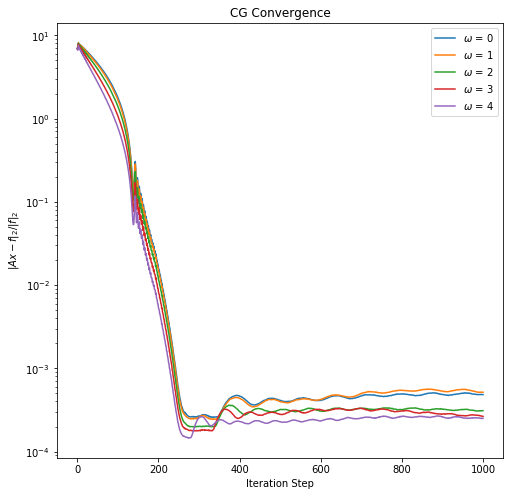

In [9]:
# Plot relative residuals for varying omega
%matplotlib inline
plt.figure(figsize=(8, 8))
plt.xlabel('Iteration Step')
plt.ylabel('$\|Ax-f\|_2 / \|f\|_2$')
plt.title('CG Convergence')
plt.yscale('log')

for i in np.arange(0, 5, 1): 
    plt.plot(residuals[1000*i:1000 + 1000*i], label=f'$\omega$ = {i}')
    plt.legend()

Here we see that up to convergence (at approx 250 iterations), the CG method converges exponentially (as seen by the aproximately linear lines on a logarithmix scale), as expected.

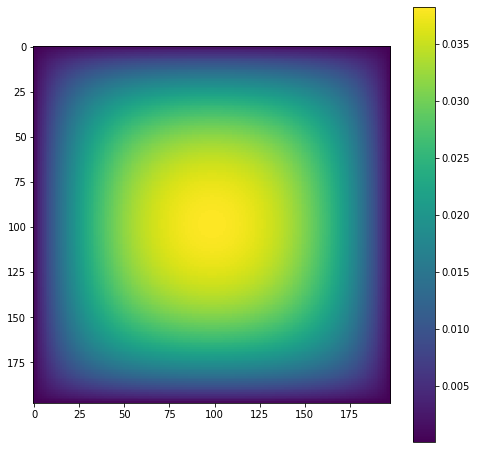

In [10]:
# Visualise solution
sol = np.reshape(sol,(N-2,N-2))
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
fig.colorbar(ax.imshow(sol))